# Comparing a DBM and a conditional GAN on an artificial dataset of simulated gene expression and SNP data

> The following example is based on the Bachelor thesis *Sampling from conditional distributions with GANs* of Frederic Boesel (2019, University of Freiburg).

We want to compare the performance of conditional sampling in deep Boltzmann machines (DBMs) and conditional generative adversarial networks (CGANs)  on a simulated example data set, which consists of artificial binary SNP and gene expression data. The gene expression and SNP data is correlated with a certain pattern. The goal for both models will be to generate new gene expression data based on given SNP data. 

## Simulation scenario

At first we simulate data using the following function. It simulates two linked data sets, one containing SNPs, and the other gene expression data. The data sets are generated as two matrices, with the samples in the columns and the variables in the rows.

The variables in the SNP data set simulate binary SNP data (e.g. homozygote SNPs) and the variables in the gene expression data set binary gene expression data (e. g. high expression vs. low expression).
The number of variables in the SNP data set is specified by `nsnpvars`, the number of variables in the gene expression data set is given by `ngepvars`.
In one quarter of the samples, the SNPs are absent with high probability (p = `1- setsnpnoiselevel` for each independent SNP to be present), in one quarter they are present with a high probability (p = `setsnpnoiselevel`) and in the rest they are randomly distributed with the `noiselevel`.
The expression of the genes 11-50 is also randomly distributed with probability `noiselevel`. Gene expression values 1 - 10, on the other hand, depend on the SNP data: The gene expression level of genes 1 - 10 is high (= 1) with probability `gepactivationprob` if the corresponding SNP is present.

The next steps show how the data is generated and visualize it.

In [43]:
function simulate_binary_snpgepdata(;
      nsamples::Int = 300,
      nsnpvars::Int = 10,
      ngepvars::Int = 50,
      setsnpnoiselevel::Float64 = 0.05,
      noiselevel::Float64 = 0.15,
      gepactivationprob::Float64 = 0.7,
      nrandomsamples::Int = 150)

   sample_bernoulli!(x, p) = map!(xi -> Float32(rand(Float32) < p), x, x)

   # simulate SNPs
   snps = zeros(Float32, nsnpvars, nsamples)
   # first quarter noisy 0s
   firstquarterofsnps = view(snps, 1:nsnpvars, 1:div(nsamples, 4))
   sample_bernoulli!(firstquarterofsnps, setsnpnoiselevel)
   # second quarter noisy 1s
   secondquarterofsnps = view(snps, 1:nsnpvars, ((div(nsamples, 4) + 1):div(nsamples, 2)))
   sample_bernoulli!(secondquarterofsnps, 1 - setsnpnoiselevel)
   # second half only noise
   secondhalfofsnps = view(snps, 1:nsnpvars, (div(nsamples, 2) + 1):nsamples)
   sample_bernoulli!(secondhalfofsnps, noiselevel)

   # simulate gene expression
   geps = zeros(Float32, ngepvars, nsamples)
   # Uncorrelated gene expressions are filled with noise
   sample_bernoulli!(geps, noiselevel)
   # gene expression for the first 10 genes depends on the SNPs
   # (high gene expression has a higher probability if the corresponding SNP is present)
   activated = (snps[1:nsnpvars, 1:(nsamples - nrandomsamples)] .== 1)
   activatedgeps = view(view(geps, 1:nsnpvars, 1:(nsamples - nrandomsamples)), activated)
   sample_bernoulli!(activatedgeps, gepactivationprob)
   notactivatedgeps = view(view(geps, 1:nsnpvars, 1:(nsamples - nrandomsamples)), .!activated)
   sample_bernoulli!(notactivatedgeps, 1 - gepactivationprob)

   snps, geps
end

simulate_binary_snpgepdata (generic function with 1 method)

In [44]:
using Random
Random.seed!(1);
snps, geps = simulate_binary_snpgepdata(nsamples = 300, nrandomsamples = 150)
test_snps, test_geps = simulate_binary_snpgepdata(nsamples = 200, nrandomsamples = 100)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[1.0 0.0 … 1.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 1.0 … 0.0 0.0; 0.0 1.0 … 1.0 0.0])

We will use the following function for having a nice view of the data sets:

In [45]:
using SparseArrays
using Gadfly
function binspy(M::AbstractMatrix) # code adapted from Gadfly.spy()
   is, js, values = findnz(sparse(M))
   n,m = size(M)
   Gadfly.plot(x=js, y=is, color=values,
         Coord.cartesian(yflip=true, fixed=true, xmin=0.5, xmax=m+.5, ymin=0.5, ymax=n+.5),
         Geom.rectbin,
         Scale.color_discrete_manual("black"),
         Guide.xlabel(""), Guide.ylabel(""),
         Theme(key_position = :none,
               grid_line_width=0mm))
end

binspy (generic function with 1 method)

The simulated SNP test dataset:

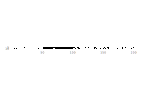

In [46]:
binspy(test_snps)

The simulated test gene expression data:

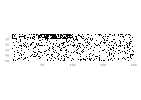

In [47]:
binspy(test_geps)

## The conditional GAN

### Training the conditional GAN on the data

Now we have the simulated data and can train a CGAN on it.

We use the Julia machine learning package [`Flux`](https://github.com/FluxML/Flux.jl) for fitting the model. The architecture can be specified via a chain of neural network layers there. The CGAN consists of two separately trained networks, the `generator`, and the `discriminator`. For more information about the model, see [Mirza and Isondero, *Conditional Generative Adversarial Nets* (2014)](https://arxiv.org/pdf/1411.1784.pdf).

In the implementation below, we weakened the discriminator by adding some noise to its loss function. For our purpose, the SNP data is used as labels (`y`) for the gene expression data (`x`).

In [48]:
struct ConditionalGAN
   discriminator
   generator
   nnoisevars::Int
   discmonitor::Vector{Float32}
   genmonitor::Vector{Float32}
end

In [49]:
using Flux # version 0.8
using Statistics

In [50]:
function fitcgan(x::AbstractMatrix{Float32}, y::AbstractMatrix{Float32};
      epochs::Int = 100,
      nnoisevars::Int = 10,
      batchsize::Int = 5,
      optimizer = ADAM(0.001),
      monitoring::Bool = true)

   discmonitor = monitoring ? Vector{Float32}(undef, epochs) : Vector{Float32}()
   genmonitor = monitoring ? Vector{Float32}(undef, epochs) : Vector{Float32}()

   nyvars = size(y, 1)
   nxvars, nsamples = size(x)
   nyzvars = nyvars + nnoisevars
   nxyvars = nxvars + nyvars

   generator = Chain(
         Dense(nyzvars, nyzvars, NNlib.leakyrelu),
         Dense(nyzvars, nxvars, NNlib.σ))

   discriminator = Chain(
         Dense(nxyvars, nxyvars, NNlib.leakyrelu),
         Dense(nxyvars, 40),
         Dense(40, 20, NNlib.leakyrelu),
         Dense(20, 1, NNlib.σ))

   untracked(m) = Flux.mapleaves(Flux.Tracker.data, m)
   generator_untracked = untracked(generator)
   discriminator_untracked = untracked(discriminator)

   disclosses = 0.0f0
   genlosses = 0.0f0

   function discloss(xy, zy, y)
      addnoise = 2 .* randn(Float32, size(Tracker.data(xy)))
      ret = - 0.5f0 * (mean(log.(discriminator(xy + addnoise) .+ eps(Float32))) +
            mean(log.(1 .- discriminator(vcat(generator_untracked(zy),y) + addnoise) 
                    .+ eps(Float32))))
      disclosses += Tracker.data(ret) / size(y, 2)
      ret
   end

   function genloss(zy, y)
      ret = - mean(log.(discriminator_untracked(vcat(generator(zy), y))) .+ eps(Float32))
      genlosses += Tracker.data(ret) / size(y, 2)
      ret
   end

   batchmasks = Iterators.partition(shuffle(1:nsamples), batchsize)

   for epoch = 1:epochs
      for batchmask in batchmasks
         xbatch = x[:, batchmask]
         ybatch = y[:, batchmask]

         actualbatchsize = size(xbatch, 2)
         zy = vcat(randn(Float32, nnoisevars, actualbatchsize), ybatch)
         xy = vcat(xbatch, ybatch)

         # discriminator training
         Flux.train!(discloss, params(discriminator), [(xy, zy, ybatch)], optimizer)

         # generator training
         Flux.train!(genloss, params(generator), [(zy, ybatch)], optimizer)
      end

      if monitoring
         genmonitor[epoch] = genlosses
         genlosses = 0.0
         discmonitor[epoch] = disclosses
         disclosses = 0.0
      end
   end

   ConditionalGAN(discriminator, generator, nnoisevars, discmonitor, genmonitor)
end

fitcgan (generic function with 1 method)

In [51]:
cgan = fitcgan(geps, snps;
      epochs = 2500,
      optimizer = ADAM(0.001),
      batchsize = 32)

ConditionalGAN(Chain(Dense(60, 60, NNlib.leakyrelu), Dense(60, 40), Dense(40, 20, NNlib.leakyrelu), Dense(20, 1, NNlib.σ)), Chain(Dense(20, 20, NNlib.leakyrelu), Dense(20, 50, NNlib.σ)), 10, Float32[0.287929, 0.254502, 0.242942, 0.236249, 0.236924, 0.235449, 0.231655, 0.236123, 0.24495, 0.237322  …  0.252112, 0.252498, 0.252559, 0.252676, 0.252325, 0.2524, 0.252577, 0.25261, 0.252815, 0.252339], Float32[0.271989, 0.315719, 0.360708, 0.382722, 0.391396, 0.387784, 0.392073, 0.386191, 0.387623, 0.390575  …  0.293935, 0.294736, 0.294202, 0.293039, 0.292703, 0.291614, 0.290474, 0.290639, 0.291201, 0.291876])

The monitoring of the loss functions, which we collected during the training, indicates that we reached a point of convergence in the training:

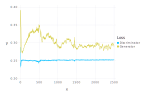

In [52]:
using DataFrames
function monitoringplot(cgan)
   plot(vcat(
         DataFrame(x = 1:length(cgan.discmonitor), y = cgan.discmonitor,
                Loss = "Discriminator"),
         DataFrame(x = 1:length(cgan.genmonitor), y = cgan.genmonitor,
                Loss = "Generator")),
         x = :x, y = :y, color = :Loss, Geom.line)
end

monitoringplot(cgan)

### Generate data from the conditional GAN
After the conditional GAN is trained, we can use it to generate new data.
To check whether it was possible to capture the original distribution of the data, 
we generate data that is conditional on the test data. 
We observe that the CGAN we trained before is able to reproduce the pattern of the gene expression data, 
thereby recognizing the links between the simulated SNP and gene expression data.


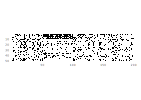

In [53]:
function generate(cgan::ConditionalGAN, y::Matrix{Float32}, nsamples::Int)
   round.(Tracker.data(cgan.generator(vcat(randn(Float32, cgan.nnoisevars, nsamples), y))))
end
generatedgeps = generate(cgan, test_snps, 200)
binspy(generatedgeps)

## The deep Boltzmann machine

### Preparing the data for the DBM

In contrast to `Flux`, which expects the samples in the columns and works with `Float32`, the `BoltzmannMachines` package expects the samples in the rows and operates with `Float64`. 

Unlike the CGAN, we do not have to give the SNP data a specific role as "labels" to use it conditional sampling later on. We simply paste the data together and let the DBM learn the joint distribution.

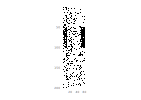

In [54]:
x = Array{Float64}(vcat(geps, snps)')
testx = Array{Float64}(vcat(test_geps, test_snps)')
binspy(testx)

### Training the DBM

In [55]:
Random.seed!(1)

using BoltzmannMachines # version 1.1

dbm = fitdbm(x;
    # network architecture
    nhiddens = [30, 10, 2],
    
    # layerwise pre-training
    learningratepretraining = 0.002, epochspretraining = 300,

    # fine-tuning (i. e. joint training of all weights as DBM)
    epochs = 100, learningrate = 0.003);

### Conditional sampling from the DBM

We sample conditioned on the test SNP data and visualize the result:

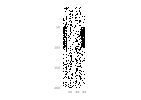

In [56]:
ntestsamples = size(testx, 1)
particles = initparticles(dbm, ntestsamples)
snprange = 51:60
particles[1][:, snprange] .= test_snps'
gibbssamplecond!(particles, dbm, snprange, 50)

binspy(particles[1])

## Conclusion: Comparison of the results from CGAN and DBM

We saw that we could train a CGAN and a DBM with the data. Both models could learn the association between SNPs and gene expression: In both cases we could sample from the conditional distributions of the SNPs to get data that is visually very close to the test gene expression data. 

Both models were not able to detect the slightly higher probabilities in the first quarter of the gene expression data with the given sample size, but got the block with the high probabilities right.

We could see some advantages of DBMs here:
* The CGAN was difficult to train: We needed the trick of weakening the discriminator with Gaussian noise to be able to get a good result.
* While the DBM could figure out the joint distribution of gene expression and SNP data on its own, we needed to design the training of the CGAN with respect to the later use: We had to specifially use the SNP data as labels in the architecture.
* The DBM reproduced the background noise level very well and did not produce visible artifacts there.
